In [36]:
import config

import logging
import numpy as np

logger = logging.getLogger(__name__)

In [37]:
import glob
import pickle
import re

files = glob.glob('embeddings/*_test.pkl')
embeddings_data = {}

for file in files:
    logger.info(f'Loading {file}')
    match_obj = re.search(r'/(?P<output>[^_/]+)_', file)
    filename = match_obj.group('output')
    with open(file, 'rb') as fp:
        dict = pickle.load(fp)
        embeddings_data[filename] = dict

2023-05-30 16:25:53,697 - INFO     | __main__   | Loading embeddings/glove_embeddings_test.pkl
2023-05-30 16:25:53,702 - INFO     | __main__   | Loading embeddings/mpnet_embeddings_test.pkl
2023-05-30 16:25:53,703 - INFO     | __main__   | Loading embeddings/distil_embeddings_test.pkl
2023-05-30 16:25:53,706 - INFO     | __main__   | Loading embeddings/wiki_embeddings_test.pkl
2023-05-30 16:25:53,709 - INFO     | __main__   | Loading embeddings/w2v_embeddings_test.pkl


In [38]:
for embeddings_model in embeddings_data.keys():
    for llm in embeddings_data[embeddings_model].keys():
        print(f"{embeddings_model}-{llm} shape: {np.array(embeddings_data[embeddings_model][llm]).shape}")

glove-bloom shape: (100, 200)
glove-alpaca_3b shape: (100, 200)
glove-alpaca_770m shape: (100, 200)
glove-llama_13b shape: (100, 200)
glove-gpt4all shape: (100, 200)
glove-llama_7b shape: (100, 200)
mpnet-bloom shape: (100, 768)
mpnet-alpaca_3b shape: (100, 768)
mpnet-alpaca_770m shape: (100, 768)
mpnet-llama_13b shape: (100, 768)
mpnet-gpt4all shape: (100, 768)
mpnet-llama_7b shape: (100, 768)
distil-bloom shape: (100, 768)
distil-alpaca_3b shape: (100, 768)
distil-alpaca_770m shape: (100, 768)
distil-llama_13b shape: (100, 768)
distil-gpt4all shape: (100, 768)
distil-llama_7b shape: (100, 768)
wiki-bloom shape: (100, 300)
wiki-alpaca_3b shape: (100, 300)
wiki-alpaca_770m shape: (100, 300)
wiki-llama_13b shape: (100, 300)
wiki-gpt4all shape: (100, 300)
wiki-llama_7b shape: (100, 300)
w2v-bloom shape: (100, 300)
w2v-alpaca_3b shape: (100, 300)
w2v-alpaca_770m shape: (100, 300)
w2v-llama_13b shape: (100, 300)
w2v-gpt4all shape: (100, 300)
w2v-llama_7b shape: (100, 300)


# Clustering

Testing on mpnet embeddings of GPT4All output.

In [39]:
mpnet_gpt4all = embeddings_data['mpnet']['gpt4all']

In [51]:
from models.clustering import ClusteringModel

kmeans = ClusteringModel(model_name='kmeans',
                         n_clusters=2,
                         max_iter=100,
                         tol=0.0056,
                         n_init='auto')

2023-05-30 16:30:09,756 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:30:09,758 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0056


In [52]:
kmeans.fit_predict(embeddings=mpnet_gpt4all, pca_flag=True, n_components=3)
clusters = kmeans.clusters
clusters

2023-05-30 16:30:21,072 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:30:21,074 - INFO     | models.clustering | Performing PCA with 3 components...


array([1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [53]:
kmeans.embeddings.shape

(100, 3)

In [54]:
from helpers.clustering_helpers import clustering_scores

kmeans_scores = clustering_scores(embeddings=mpnet_gpt4all, clusters=clusters)

2023-05-30 16:30:23,482 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.121628237960316
2023-05-30 16:30:23,486 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.488459678586155
2023-05-30 16:30:23,488 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.1444210559129715


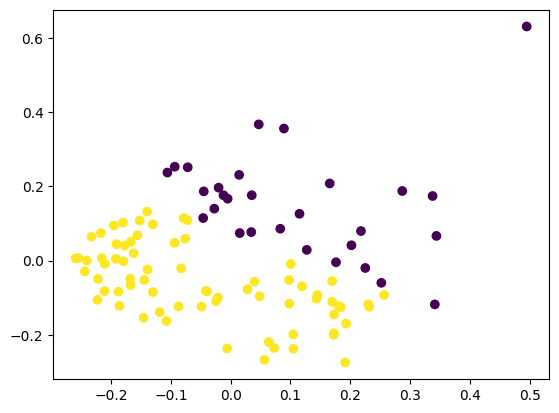

In [55]:
from helpers.data_viz import plot_clusters

plot_clusters(embeddings=kmeans.embeddings, clusters=clusters)

# Hyperparameters Search

In [45]:
n_components_space = [16, 32, 64, 100]
min_samples_space = [5, 10, 15, 20]

res = {}
res['n_components'] = []
res['min_samples'] = []
res['score'] = []

for n_components in n_components_space:
    for min_samples in min_samples_space:
        dbscan = ClusteringModel(model_name='dbscan',
                                 min_samples=min_samples,
                                 metric='euclidean',
                                 eps=0.5)

        dbscan.fit_predict(embeddings=mpnet_gpt4all, pca_flag=True, n_components=n_components)

        try:
            scores = clustering_scores(embeddings=mpnet_gpt4all, clusters=dbscan.clusters)['silhouette']
        except Exception as e:
            print(e)
            scores = -np.inf

        res['n_components'].append(n_components)
        res['min_samples'].append(min_samples)
        res['score'].append(scores)

2023-05-30 16:26:06,614 - INFO     | models.clustering | Initializing DBSCAN
2023-05-30 16:26:06,616 - INFO     | models.clustering | EPS: 0.5 - MIN_SAMPLES: 5 - METRIC: euclidean
2023-05-30 16:26:06,618 - INFO     | models.clustering | DBSCAN: searching clusters...
2023-05-30 16:26:06,619 - INFO     | models.clustering | Performing PCA with 16 components...
2023-05-30 16:26:06,709 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 4.881762086044153
2023-05-30 16:26:06,709 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.1087295245239392
2023-05-30 16:26:06,711 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.3223799765110016
2023-05-30 16:26:06,712 - INFO     | models.clustering | Initializing DBSCAN
2023-05-30 16:26:06,714 - INFO     | models.clustering | EPS: 0.5 - MIN_SAMPLES: 10 - METRIC: euclidean
2023-05-30 16:26:06,717 - INFO     | models.clustering | DBSCAN: searching clusters...
2023-05-30 16:26:06,718 - INFO     | models.clusteri

2023-05-30 16:26:10,442 - INFO     | models.clustering | EPS: 0.5 - MIN_SAMPLES: 5 - METRIC: euclidean
2023-05-30 16:26:10,442 - INFO     | models.clustering | DBSCAN: searching clusters...
2023-05-30 16:26:10,445 - INFO     | models.clustering | Performing PCA with 100 components...
2023-05-30 16:26:10,622 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.192494447294163
2023-05-30 16:26:10,623 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.860783333155428
2023-05-30 16:26:10,625 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09400931000709534
2023-05-30 16:26:10,629 - INFO     | models.clustering | Initializing DBSCAN
2023-05-30 16:26:10,630 - INFO     | models.clustering | EPS: 0.5 - MIN_SAMPLES: 10 - METRIC: euclidean
2023-05-30 16:26:10,631 - INFO     | models.clustering | DBSCAN: searching clusters...
2023-05-30 16:26:10,632 - INFO     | models.clustering | Performing PCA with 100 components...
2023-05-30 16:26:10,793 - INFO   

In [46]:
# Convert the lists in 'res' to NumPy arrays for easier manipulation
res_array = {key: np.array(value) for key, value in res.items()}

# Find the index of the best score
best_score_index = np.argmax(res_array['score'])

# Extract the best score and its associated parameters
best_score = res_array['score'][best_score_index]
best_n_components = res_array['n_components'][best_score_index]
best_min_samples = res_array['min_samples'][best_score_index]

print(f"Best Score: {best_score}")
print(f"Associated Parameters:")
print(f"n_components: {best_n_components}")
print(f"min_samples: {best_min_samples}")

Best Score: 0.3223799765110016
Associated Parameters:
n_components: 16
min_samples: 5


In [47]:
n_components_space = [16, 32, 64, 100]
n_clusters_space = [2, 3, 4, 5]
max_iter_space = [100, 250, 500, 750, 1000]
tol_space = np.linspace(0.0001, 0.01, 10)

res = {}
res['n_clusters'] = []
res['max_iter'] = []
res['tol'] = []
res['n_components'] = []
res['score'] = []

for n_components in n_clusters_space:
    for n_clusters in n_clusters_space:
        for max_iter in max_iter_space:
            for tol in tol_space:
                kmeans = ClusteringModel(model_name='kmeans',
                                         n_clusters=n_clusters,
                                         max_iter=max_iter,
                                         tol=tol,
                                         n_init='auto')

                kmeans.fit_predict(embeddings=mpnet_gpt4all, pca_flag=True, n_components=n_components)

                try:
                    scores = clustering_scores(embeddings=mpnet_gpt4all, clusters=kmeans.clusters)['silhouette']
                except Exception as e:
                    print(e)
                    scores = -np.inf

                res['n_components'].append(n_components)
                res['max_iter'].append(max_iter)
                res['n_clusters'].append(n_clusters)
                res['tol'].append(tol)
                res['score'].append(scores)

2023-05-30 16:26:16,796 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:16,799 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0001
2023-05-30 16:26:16,801 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:16,801 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:16,910 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:16,911 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:16,914 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:16,917 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:16,919 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0012000000000000001
2023-05-30 16:26:16,919 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:16,921 - INFO     | model

2023-05-30 16:26:17,249 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:17,251 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0023
2023-05-30 16:26:17,262 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:17,266 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:17,315 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:17,316 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:17,319 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:17,325 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:17,337 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0034
2023-05-30 16:26:17,341 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:17,356 - INFO     | models.clustering | 

2023-05-30 16:26:17,833 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:17,834 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.0045000000000000005
2023-05-30 16:26:17,835 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:17,837 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:17,856 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:17,857 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:17,858 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:17,858 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:17,859 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.005600000000000001
2023-05-30 16:26:17,860 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:17,862 - IN

2023-05-30 16:26:18,257 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:18,269 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 750 - TOL: 0.0067
2023-05-30 16:26:18,271 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:18,278 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:18,370 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:18,371 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:18,372 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:18,373 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:18,374 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 750 - TOL: 0.0078000000000000005
2023-05-30 16:26:18,375 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:18,375 - INFO     | model

2023-05-30 16:26:18,874 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:18,878 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 1000 - TOL: 0.0089
2023-05-30 16:26:18,878 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:18,878 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:18,902 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:18,903 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:18,906 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:18,906 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:18,907 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 1000 - TOL: 0.01
2023-05-30 16:26:18,907 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:18,908 - INFO     | models.clustering | 

2023-05-30 16:26:19,337 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:19,338 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 250 - TOL: 0.0001
2023-05-30 16:26:19,339 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:19,340 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:19,361 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.160331423938981
2023-05-30 16:26:19,362 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9644685733686096
2023-05-30 16:26:19,363 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08426421135663986
2023-05-30 16:26:19,363 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:19,364 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 250 - TOL: 0.0012000000000000001
2023-05-30 16:26:19,365 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:19,367 - INFO     | model

2023-05-30 16:26:20,023 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:20,025 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.0023
2023-05-30 16:26:20,026 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:20,028 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:20,051 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.160331423938981
2023-05-30 16:26:20,053 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9644685733686096
2023-05-30 16:26:20,055 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08426421135663986
2023-05-30 16:26:20,057 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:20,058 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.0034
2023-05-30 16:26:20,058 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:20,060 - INFO     | models.clustering | 

2023-05-30 16:26:20,742 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:20,743 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.0045000000000000005
2023-05-30 16:26:20,745 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:20,747 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:20,764 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.160331423938981
2023-05-30 16:26:20,765 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9644685733686096
2023-05-30 16:26:20,767 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08426421135663986
2023-05-30 16:26:20,768 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:20,770 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.005600000000000001
2023-05-30 16:26:20,770 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:20,771 - IN

2023-05-30 16:26:21,244 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:21,245 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 1000 - TOL: 0.0067
2023-05-30 16:26:21,247 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:21,248 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:21,268 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.160331423938981
2023-05-30 16:26:21,269 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9644685733686096
2023-05-30 16:26:21,270 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08426421135663986
2023-05-30 16:26:21,272 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:21,273 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 1000 - TOL: 0.0078000000000000005
2023-05-30 16:26:21,274 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:21,275 - INFO     | mod

2023-05-30 16:26:21,619 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:21,620 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.0089
2023-05-30 16:26:21,621 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:21,621 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:21,636 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.836841245228722
2023-05-30 16:26:21,637 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.8373257739147184
2023-05-30 16:26:21,644 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.07047509402036667
2023-05-30 16:26:21,645 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:21,646 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.01
2023-05-30 16:26:21,648 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:21,649 - INFO     | models.clustering | Pe

2023-05-30 16:26:22,063 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 500 - TOL: 0.0001
2023-05-30 16:26:22,071 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:22,076 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:22,149 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.864125158250087
2023-05-30 16:26:22,149 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.812478653030565
2023-05-30 16:26:22,152 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.07381735742092133
2023-05-30 16:26:22,153 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:22,155 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 500 - TOL: 0.0012000000000000001
2023-05-30 16:26:22,155 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:22,157 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:22,189 - I

2023-05-30 16:26:23,002 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0023
2023-05-30 16:26:23,003 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:23,004 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:23,087 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.836841245228722
2023-05-30 16:26:23,088 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.8373257739147184
2023-05-30 16:26:23,090 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.07047509402036667
2023-05-30 16:26:23,091 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:23,093 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0034
2023-05-30 16:26:23,094 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:23,096 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:23,117 - INFO     | help

2023-05-30 16:26:23,511 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.0045000000000000005
2023-05-30 16:26:23,512 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:23,514 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:23,554 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.836841245228722
2023-05-30 16:26:23,555 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.8373257739147184
2023-05-30 16:26:23,556 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.07047509402036667
2023-05-30 16:26:23,557 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:23,558 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.005600000000000001
2023-05-30 16:26:23,559 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:23,559 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30

2023-05-30 16:26:24,234 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 100 - TOL: 0.0067
2023-05-30 16:26:24,239 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:24,244 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:24,275 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 5.660235396997791
2023-05-30 16:26:24,275 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.004866751991732
2023-05-30 16:26:24,276 - INFO     | helpers.clustering_helpers | Silhouette Score: -0.022483788430690765
2023-05-30 16:26:24,277 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:24,278 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 100 - TOL: 0.0078000000000000005
2023-05-30 16:26:24,279 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:24,280 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:24,299 -

2023-05-30 16:26:24,700 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.0089
2023-05-30 16:26:24,701 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:24,705 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:24,729 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 5.660235396997791
2023-05-30 16:26:24,730 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.004866751991732
2023-05-30 16:26:24,731 - INFO     | helpers.clustering_helpers | Silhouette Score: -0.022483788430690765
2023-05-30 16:26:24,733 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:24,734 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.01
2023-05-30 16:26:24,735 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:24,736 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:24,763 - INFO     | helpe

2023-05-30 16:26:25,305 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 750 - TOL: 0.0001
2023-05-30 16:26:25,310 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:25,313 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:25,341 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 5.660235396997791
2023-05-30 16:26:25,342 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.004866751991732
2023-05-30 16:26:25,343 - INFO     | helpers.clustering_helpers | Silhouette Score: -0.022483788430690765
2023-05-30 16:26:25,343 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:25,344 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 750 - TOL: 0.0012000000000000001
2023-05-30 16:26:25,348 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:25,352 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:25,383 -

2023-05-30 16:26:25,722 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0023
2023-05-30 16:26:25,723 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:25,724 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:25,750 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 5.660235396997791
2023-05-30 16:26:25,751 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.004866751991732
2023-05-30 16:26:25,755 - INFO     | helpers.clustering_helpers | Silhouette Score: -0.022483788430690765
2023-05-30 16:26:25,758 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:25,761 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0034
2023-05-30 16:26:25,767 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:25,770 - INFO     | models.clustering | Performing PCA with 2 components...
2023-05-30 16:26:25,882 - INFO     | h

2023-05-30 16:26:26,371 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0045000000000000005
2023-05-30 16:26:26,378 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:26,383 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:26,442 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.13707590668333
2023-05-30 16:26:26,443 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.5115552585882854
2023-05-30 16:26:26,444 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.14267706871032715
2023-05-30 16:26:26,453 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:26,459 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.005600000000000001
2023-05-30 16:26:26,463 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:26,467 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16

2023-05-30 16:26:26,963 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0067
2023-05-30 16:26:26,964 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:26,965 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:26,991 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.8245723548489465
2023-05-30 16:26:26,992 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.566410686938835
2023-05-30 16:26:26,993 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.12150534987449646
2023-05-30 16:26:26,995 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:26,997 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0078000000000000005
2023-05-30 16:26:26,999 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:27,001 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:27,019 - 

2023-05-30 16:26:27,546 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.0089
2023-05-30 16:26:27,551 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:27,552 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:27,580 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 6.569342416781851
2023-05-30 16:26:27,581 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.6523215890407807
2023-05-30 16:26:27,583 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11556240171194077
2023-05-30 16:26:27,584 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:27,586 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.01
2023-05-30 16:26:27,586 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:27,588 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:27,609 - INFO     | helper

2023-05-30 16:26:28,125 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:28,126 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:28,151 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.13707590668333
2023-05-30 16:26:28,152 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.5115552585882854
2023-05-30 16:26:28,154 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.14267706871032715
2023-05-30 16:26:28,155 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:28,156 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 1000 - TOL: 0.0012000000000000001
2023-05-30 16:26:28,160 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:28,161 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:28,180 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.13707590668333
2023-05-30 16:26:28

2023-05-30 16:26:28,699 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:28,700 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:28,720 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:28,721 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9525101171838855
2023-05-30 16:26:28,725 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08907373249530792
2023-05-30 16:26:28,727 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:28,728 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 100 - TOL: 0.0034
2023-05-30 16:26:28,730 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:28,731 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:28,751 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:28,752 - INFO   

2023-05-30 16:26:29,282 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:29,283 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:29,313 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:29,314 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9525101171838855
2023-05-30 16:26:29,317 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08907373249530792
2023-05-30 16:26:29,318 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:29,320 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 250 - TOL: 0.005600000000000001
2023-05-30 16:26:29,320 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:29,322 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:29,353 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:29

2023-05-30 16:26:29,998 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:30,004 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:30,034 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:30,036 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9525101171838855
2023-05-30 16:26:30,036 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08907373249530792
2023-05-30 16:26:30,037 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:30,038 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.0078000000000000005
2023-05-30 16:26:30,039 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:30,040 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:30,062 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:3

2023-05-30 16:26:30,614 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:30,615 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:30,642 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:30,644 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.9525101171838855
2023-05-30 16:26:30,646 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08907373249530792
2023-05-30 16:26:30,652 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:30,654 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.01
2023-05-30 16:26:30,659 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:30,662 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:30,740 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200637600876243
2023-05-30 16:26:30,740 - INFO     

2023-05-30 16:26:31,077 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:31,079 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:31,116 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:31,117 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:31,119 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:31,120 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:31,122 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.0012000000000000001
2023-05-30 16:26:31,123 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:31,124 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:31,167 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:31,168

2023-05-30 16:26:31,547 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:31,567 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:31,568 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:31,570 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:31,571 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:31,573 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 250 - TOL: 0.0034
2023-05-30 16:26:31,574 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:31,575 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:31,607 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:31,608 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:31

2023-05-30 16:26:32,086 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:32,087 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:32,087 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:32,088 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:32,089 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 500 - TOL: 0.005600000000000001
2023-05-30 16:26:32,091 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:32,093 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:32,116 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:32,117 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:32,117 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.088856875896

2023-05-30 16:26:32,691 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:32,692 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:32,693 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:32,694 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0078000000000000005
2023-05-30 16:26:32,698 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:32,703 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:32,779 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:32,780 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:32,781 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:32,783 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:32,785

2023-05-30 16:26:33,248 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:33,249 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:33,251 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.01
2023-05-30 16:26:33,252 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:33,254 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:33,283 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.0433962428296
2023-05-30 16:26:33,284 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.214059027215731
2023-05-30 16:26:33,287 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08885687589645386
2023-05-30 16:26:33,288 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:33,289 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 100 - TOL: 0.0001
2023-05-30 16:26:33,290 - INFO     | models.

2023-05-30 16:26:33,777 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:33,781 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.0012000000000000001
2023-05-30 16:26:33,781 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:33,782 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:33,802 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:33,803 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.14766448607919
2023-05-30 16:26:33,806 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08704917877912521
2023-05-30 16:26:33,808 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:33,809 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.0023
2023-05-30 16:26:33,810 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:33,811 - INFO     | models.

2023-05-30 16:26:34,492 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 500 - TOL: 0.0034
2023-05-30 16:26:34,494 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:34,495 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:34,544 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:34,546 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.14766448607919
2023-05-30 16:26:34,547 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08704917877912521
2023-05-30 16:26:34,548 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:34,549 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 500 - TOL: 0.0045000000000000005
2023-05-30 16:26:34,549 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:34,552 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:34,583 - IN

2023-05-30 16:26:35,213 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:35,215 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:35,247 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:35,248 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.14766448607919
2023-05-30 16:26:35,253 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08704917877912521
2023-05-30 16:26:35,255 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:35,256 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 750 - TOL: 0.0067
2023-05-30 16:26:35,258 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:35,261 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:35,282 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:35,282 - INFO     

2023-05-30 16:26:35,991 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:36,025 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:36,026 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.14766448607919
2023-05-30 16:26:36,026 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08704917877912521
2023-05-30 16:26:36,027 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:36,028 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0089
2023-05-30 16:26:36,032 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:36,036 - INFO     | models.clustering | Performing PCA with 3 components...
2023-05-30 16:26:36,078 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.525996841905196
2023-05-30 16:26:36,080 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.14766448607919
2023-05-30 16:26

2023-05-30 16:26:36,583 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:36,584 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:36,585 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:36,586 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:36,588 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0001
2023-05-30 16:26:36,588 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:36,589 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:36,633 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:36,638 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:36,640 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
20

2023-05-30 16:26:37,368 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:37,369 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:37,370 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:37,371 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:37,372 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.0023
2023-05-30 16:26:37,373 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:37,375 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:37,450 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:37,451 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:37,452 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
20

2023-05-30 16:26:37,933 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:37,934 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:37,935 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:37,937 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:37,938 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 750 - TOL: 0.0045000000000000005
2023-05-30 16:26:37,939 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:37,940 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:37,956 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:37,958 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:37,958 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413

2023-05-30 16:26:38,307 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:38,308 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:38,310 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:38,312 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:38,313 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 1000 - TOL: 0.0067
2023-05-30 16:26:38,315 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:38,316 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:38,333 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:38,334 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:38,335 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2

2023-05-30 16:26:38,801 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200117170692845
2023-05-30 16:26:38,802 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:38,803 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:38,807 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:38,814 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 100 - TOL: 0.0089
2023-05-30 16:26:38,818 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:38,824 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:38,947 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200117170692845
2023-05-30 16:26:38,948 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:38,953 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023

2023-05-30 16:26:39,480 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:39,482 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:39,484 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:39,486 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.0001
2023-05-30 16:26:39,487 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:39,489 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:39,518 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200117170692845
2023-05-30 16:26:39,519 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:39,520 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:39,523 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:39,529 - INFO     |

2023-05-30 16:26:40,150 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:40,151 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:40,157 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:40,163 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.0023
2023-05-30 16:26:40,165 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:40,171 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:40,250 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200117170692845
2023-05-30 16:26:40,251 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:40,253 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:40,255 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:40,261 - INFO     |

2023-05-30 16:26:41,053 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:41,056 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:41,058 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 1000 - TOL: 0.0045000000000000005
2023-05-30 16:26:41,059 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:41,060 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:41,106 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.200117170692845
2023-05-30 16:26:41,107 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.948371592435047
2023-05-30 16:26:41,108 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08653184771537781
2023-05-30 16:26:41,112 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:41,114 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 1000 - TOL: 0.005600000000000001
2023-05-30

2023-05-30 16:26:41,803 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08772177994251251
2023-05-30 16:26:41,814 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:41,819 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.0067
2023-05-30 16:26:41,827 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:41,837 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:41,921 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.066492018322917
2023-05-30 16:26:41,922 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.27621806340212
2023-05-30 16:26:41,923 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08772177994251251
2023-05-30 16:26:41,924 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:41,927 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.0078000000000000005
2023-05-30 16:26:41,929 - I

2023-05-30 16:26:42,485 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:42,494 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 250 - TOL: 0.0089
2023-05-30 16:26:42,498 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:42,499 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:42,539 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.066492018322917
2023-05-30 16:26:42,541 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.27621806340212
2023-05-30 16:26:42,542 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08772177994251251
2023-05-30 16:26:42,549 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:42,550 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 250 - TOL: 0.01
2023-05-30 16:26:42,551 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:42,551 - INFO     | models.clustering | Perf

2023-05-30 16:26:43,295 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0001
2023-05-30 16:26:43,297 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:43,299 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:43,325 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.066492018322917
2023-05-30 16:26:43,326 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.27621806340212
2023-05-30 16:26:43,328 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08772177994251251
2023-05-30 16:26:43,328 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:43,330 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0012000000000000001
2023-05-30 16:26:43,330 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:43,331 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:43,350 - IN

2023-05-30 16:26:43,949 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:43,950 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:43,975 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.066492018322917
2023-05-30 16:26:43,977 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.27621806340212
2023-05-30 16:26:43,979 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08772177994251251
2023-05-30 16:26:43,980 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:43,984 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.0034
2023-05-30 16:26:43,984 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:43,985 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:44,002 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.066492018322917
2023-05-30 16:26:44,004 - INFO    

2023-05-30 16:26:44,493 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:44,539 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:44,540 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:44,540 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:44,541 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:44,543 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 100 - TOL: 0.005600000000000001
2023-05-30 16:26:44,546 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:44,548 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:44,612 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:44,612 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
202

2023-05-30 16:26:45,051 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:45,051 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:45,052 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:45,054 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:45,055 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.0078000000000000005
2023-05-30 16:26:45,056 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:45,057 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:45,080 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:45,081 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:45,082 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.090243890

2023-05-30 16:26:45,709 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:45,710 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:45,712 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:45,713 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 500 - TOL: 0.01
2023-05-30 16:26:45,715 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:45,716 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:45,734 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:45,735 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:45,736 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:45,737 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:45,738 - INFO     | mo

2023-05-30 16:26:46,127 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:46,127 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:46,130 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0012000000000000001
2023-05-30 16:26:46,130 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:46,131 - INFO     | models.clustering | Performing PCA with 4 components...
2023-05-30 16:26:46,153 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.34200685103082
2023-05-30 16:26:46,159 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.189866983833592
2023-05-30 16:26:46,160 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.09024389088153839
2023-05-30 16:26:46,164 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:46,166 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0023
2023-05-30 16:26:46,167 -

2023-05-30 16:26:46,794 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:46,804 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:46,817 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0034
2023-05-30 16:26:46,829 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:46,832 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:46,909 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:46,910 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:46,912 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:46,912 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:46,914 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 100 - TOL: 0.0045000000000000005
2023-05-30 16:26:46,915 -

2023-05-30 16:26:47,453 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:47,454 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:47,455 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.005600000000000001
2023-05-30 16:26:47,458 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:47,461 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:47,524 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:47,524 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:47,525 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:47,526 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:47,527 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 250 - TOL: 0.0067
2023-05-30 16:26:47,528 - 

2023-05-30 16:26:47,948 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:47,952 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:47,952 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.0078000000000000005
2023-05-30 16:26:47,954 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:47,956 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:47,975 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:47,976 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:47,977 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:47,979 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:47,981 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 500 - TOL: 0.0089
2023-05-30 16:26:47,982 -

2023-05-30 16:26:48,377 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:48,377 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:48,378 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 750 - TOL: 0.01
2023-05-30 16:26:48,379 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:48,381 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:48,546 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 9.967858768689375
2023-05-30 16:26:48,548 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 3.0081827321173202
2023-05-30 16:26:48,549 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.11413581669330597
2023-05-30 16:26:48,553 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:48,560 - INFO     | models.clustering | N_CLUSTERS: 2 - MAX_ITER: 1000 - TOL: 0.0001
2023-05-30 16:26:48,564 - INFO     | mode

2023-05-30 16:26:49,224 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:49,226 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:49,228 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 100 - TOL: 0.0012000000000000001
2023-05-30 16:26:49,230 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:49,231 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:49,263 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.183057847974839
2023-05-30 16:26:49,265 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.987058002834374
2023-05-30 16:26:49,266 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:49,267 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:49,268 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 100 - TOL: 0.0023
2023-05-30 16:26:49,269 - 

2023-05-30 16:26:49,827 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:49,829 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:49,830 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 250 - TOL: 0.0034
2023-05-30 16:26:49,833 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:49,835 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:49,866 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.183057847974839
2023-05-30 16:26:49,868 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.987058002834374
2023-05-30 16:26:49,869 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:49,871 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:49,871 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 250 - TOL: 0.0045000000000000005
2023-05-30 16:26:49,872 - 

2023-05-30 16:26:50,538 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:50,539 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:50,542 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.005600000000000001
2023-05-30 16:26:50,544 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:50,547 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:50,586 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.183057847974839
2023-05-30 16:26:50,586 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.987058002834374
2023-05-30 16:26:50,587 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:50,589 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:50,590 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 500 - TOL: 0.0067
2023-05-30 16:26:50,592 - I

2023-05-30 16:26:51,235 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:51,235 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:51,237 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.0078000000000000005
2023-05-30 16:26:51,238 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:51,240 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:51,261 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.183057847974839
2023-05-30 16:26:51,264 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.987058002834374
2023-05-30 16:26:51,265 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:51,266 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:51,267 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 750 - TOL: 0.0089
2023-05-30 16:26:51,268 - 

2023-05-30 16:26:51,993 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:51,995 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:51,996 - INFO     | models.clustering | N_CLUSTERS: 3 - MAX_ITER: 1000 - TOL: 0.01
2023-05-30 16:26:51,999 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:52,001 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:52,021 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 8.183057847974839
2023-05-30 16:26:52,022 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.987058002834374
2023-05-30 16:26:52,023 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08141252398490906
2023-05-30 16:26:52,023 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:52,024 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 100 - TOL: 0.0001
2023-05-30 16:26:52,026 - INFO     | model

2023-05-30 16:26:52,361 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:52,362 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 250 - TOL: 0.0012000000000000001
2023-05-30 16:26:52,363 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:52,364 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:52,383 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.984857736105375
2023-05-30 16:26:52,386 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.340545969002237
2023-05-30 16:26:52,387 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08479127287864685
2023-05-30 16:26:52,389 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:52,390 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 250 - TOL: 0.0023
2023-05-30 16:26:52,391 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:52,393 - INFO     | models

2023-05-30 16:26:53,068 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:53,069 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 500 - TOL: 0.0034
2023-05-30 16:26:53,070 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:53,073 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:53,090 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.984857736105375
2023-05-30 16:26:53,093 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.340545969002237
2023-05-30 16:26:53,095 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08479127287864685
2023-05-30 16:26:53,096 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:53,098 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 500 - TOL: 0.0045000000000000005
2023-05-30 16:26:53,101 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:53,102 - INFO     | models

2023-05-30 16:26:53,808 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:53,811 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.005600000000000001
2023-05-30 16:26:53,813 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:53,814 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:53,830 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.984857736105375
2023-05-30 16:26:53,831 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.340545969002237
2023-05-30 16:26:53,832 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08479127287864685
2023-05-30 16:26:53,833 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:53,835 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 750 - TOL: 0.0067
2023-05-30 16:26:53,837 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:53,839 - INFO     | models.

2023-05-30 16:26:54,413 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:54,415 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.0078000000000000005
2023-05-30 16:26:54,416 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:54,417 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:54,494 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.984857736105375
2023-05-30 16:26:54,498 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.340545969002237
2023-05-30 16:26:54,501 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08479127287864685
2023-05-30 16:26:54,502 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:54,503 - INFO     | models.clustering | N_CLUSTERS: 4 - MAX_ITER: 1000 - TOL: 0.0089
2023-05-30 16:26:54,504 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:54,506 - INFO     | mode

2023-05-30 16:26:55,327 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:55,328 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 100 - TOL: 0.01
2023-05-30 16:26:55,329 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:55,332 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:55,351 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.100457858153856
2023-05-30 16:26:55,352 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.2325431319208784
2023-05-30 16:26:55,354 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08827624469995499
2023-05-30 16:26:55,355 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:55,357 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 250 - TOL: 0.0001
2023-05-30 16:26:55,359 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:55,360 - INFO     | models.clustering | Pe

2023-05-30 16:26:55,875 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 500 - TOL: 0.0012000000000000001
2023-05-30 16:26:55,876 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:55,877 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:55,908 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.100457858153856
2023-05-30 16:26:55,909 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.2325431319208784
2023-05-30 16:26:55,910 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08827624469995499
2023-05-30 16:26:55,911 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:55,912 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 500 - TOL: 0.0023
2023-05-30 16:26:55,914 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:55,915 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:55,953 - 

2023-05-30 16:26:56,639 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 750 - TOL: 0.0034
2023-05-30 16:26:56,640 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:56,643 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:56,684 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.100457858153856
2023-05-30 16:26:56,685 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.2325431319208784
2023-05-30 16:26:56,686 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08827624469995499
2023-05-30 16:26:56,687 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:56,688 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 750 - TOL: 0.0045000000000000005
2023-05-30 16:26:56,689 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:56,690 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:56,712 - 

2023-05-30 16:26:57,325 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.005600000000000001
2023-05-30 16:26:57,326 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:57,329 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:57,352 - INFO     | helpers.clustering_helpers | Calinski-Harabasz Index: 7.100457858153856
2023-05-30 16:26:57,354 - INFO     | helpers.clustering_helpers | Davies-Bouldin Index: 2.2325431319208784
2023-05-30 16:26:57,355 - INFO     | helpers.clustering_helpers | Silhouette Score: 0.08827624469995499
2023-05-30 16:26:57,356 - INFO     | models.clustering | Initializing KMEANS
2023-05-30 16:26:57,357 - INFO     | models.clustering | N_CLUSTERS: 5 - MAX_ITER: 1000 - TOL: 0.0067
2023-05-30 16:26:57,357 - INFO     | models.clustering | KMEANS: searching clusters...
2023-05-30 16:26:57,357 - INFO     | models.clustering | Performing PCA with 5 components...
2023-05-30 16:26:57,379 -

In [49]:
# Convert the lists in 'res' to NumPy arrays for easier manipulation
res_array = {key: np.array(value) for key, value in res.items()}

# Find the index of the best score
best_score_index = np.argmax(res_array['score'])

# Extract the best score and its associated parameters
best_score = res_array['score'][best_score_index]
best_n_components = res_array['n_components'][best_score_index]
best_max_iter = res_array['max_iter'][best_score_index]
best_n_clusters = res_array['n_clusters'][best_score_index]
best_tol = res_array['tol'][best_score_index]

print(f"Best Score: {best_score}")
print(f"Associated Parameters:")
print(f"n_components: {best_n_components}")
print(f"max_iter: {best_max_iter}")
print(f"n_clusters: {best_n_clusters}")
print(f"tol: {best_tol}")

Best Score: 0.1444210559129715
Associated Parameters:
n_components: 3
min_samples: 100
n_clusters: 2
tol: 0.005600000000000001
